In [4]:
import librosa
import librosa.display
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import sys
import scipy.signal

sys.path.append('../')

In [3]:
from src.worker.draw import draw_filtered
from src.worker.shazam_fingerprint import get_hashes_from_peaks

recording, sr = librosa.load(
    "/Users/duongtat/Work/_skola/VMM/tmp/7d3119ed1bb6bc9e65b3ed000.wav")
music, sr = librosa.load(
    "/Users/duongtat/Work/_skola/VMM/dataset/REEBOKS OR THE NIKES [fbHxkNa7lhQ].wav")


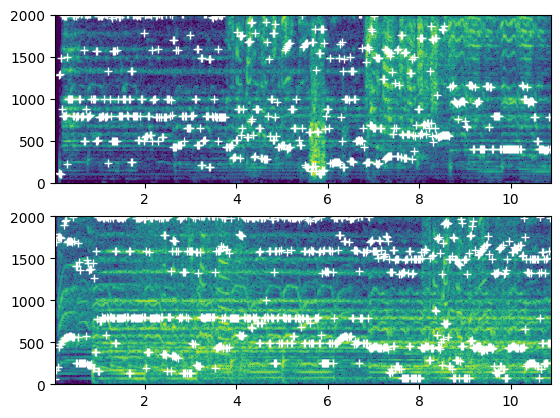

In [7]:
def get_peak_frequencies(y, sr=22_050, n_fft=2_048, hop_length=2_048//4):
    """
    Extract peak frequencies for each FFT frame
    """
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

    all_frames = np.arange(S.shape[1])
    all_bins = np.arange(S.shape[0])

    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    times = librosa.frames_to_time(
        all_frames,
        sr=sr,
        hop_length=hop_length,
        n_fft=n_fft
    )

    S_out = np.zeros_like(S, dtype=np.bool8)

    for time_bin, window in enumerate(S.T):
        peaks, props = scipy.signal.find_peaks(
            window, prominence=0, distance=100)

        num_peaks = min(peaks.shape[-1], 5)
        freq_bins = peaks[
            np.argpartition(props["prominences"], -num_peaks)[-num_peaks:]]

        S_out[freq_bins, time_bin] = True

    result = np.apply_along_axis(
        lambda key: np.array(
            [frequencies[key[0]], times[key[1]]]
        ),
        1,
        np.argwhere(S_out > 0)
    )

    result = result[result[:, 0].argsort()]
    result = result[result[:, 1].argsort(kind="mergesort")]

    return result


fig, ax = plt.subplots(2, 1)

draw_filtered(recording, get_peak_frequencies, fig=ax[0])
draw_filtered(music[:recording.shape[-1]], get_peak_frequencies, fig=ax[1])
